Are there sites inaccessible from one technology / technique vs another?
  - I bet there are sites where non-nist WGS all miss but every TR caller captures
  - I bet there are sites long reads capture but none of the short reads capture
  
Take the refine.regions.txt from all tools and combine like how I'm doing for Q4.
Perform queries based on path.txt metadata's sequencing,  Caller Type,  Sequencing, Locations.

Where do each subset all agree / disagree with one another.

wgs vs catalog (pretty much same as TR vs non-TR). 
Short-reads vs long reads


In [2]:
import os
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import json

In [172]:
def region_loader(path, name):
    full_path = os.path.join(path, 'refine.regions.txt')
    benchmark_regions = pd.read_csv(full_path, 
                                #names=["chrom", "start", "end", "tier", "repl", "vflag", "entropy", "ad1", "ad2"],
                                sep='\t').set_index(["chrom", "start", "end"])
    benchmark_regions.columns = [f'{c}_{name}' for c in benchmark_regions.columns]
    return benchmark_regions
paths = pd.read_csv("paths_hd.txt", sep='\t')
paths = paths[paths['program'].isin(['biograph', 
                                     'deepvariant', 
                                     'gangstr', 
                                     'hipstr', 
                                     'medakaTR', 
                                     'sniffles', 
                                     'trgt', 
                                     'GIABv4.2.1'])]
parts = []
for _, i in paths.iterrows():
    parts.append(region_loader(i['path'], i['program']))
data = pd.concat(parts, axis=1)

In [173]:
# When doing the agreement, we want for all tier1 sites as well as for all >=5bp
# Lets repeat all of that with Tier1

benchmark_regions = pd.read_csv("/Users/english/code/adotto/benchmark/GIABTR_benchmark.6.26/GIABTR.HG002.benchmark.regions.bed.gz", 
                                names=["chrom", "start", "end", "tier", "repl", "vflag", "entropy", "ad1", "ad2"],
                                sep='\t').set_index(["chrom", "start", "end"])

benchmark_regions['max_allele_delta'] = benchmark_regions[['ad1', 'ad2']].max(axis=1)
s = benchmark_regions.reset_index()
x = (s['end'] - s['start']).to_frame().set_index(benchmark_regions.index)
benchmark_regions['span'] = x

# Want to load the catalog and also do this grouping for the mean purity of the repeats
catalog = (pd.read_csv("/Users/english/code/adotto/regions/adotto_TRregions_v1.1.bed", sep='\t')
           .rename(columns={'chr':'chrom'})
           .set_index(['chrom', 'start', 'end']))


def max_motif(x):
    d = json.loads(x)
    return max([_['period'] for _ in d])
catalog['max_motif'] = catalog['annos'].apply(max_motif)


benchmark_regions = benchmark_regions.join(catalog[['mu_purity', 'max_motif']])

t1_index = benchmark_regions[benchmark_regions['tier'] == 'Tier1'].index

def is_gt5(x):
    return (x & 0x1) != 0
gt5_index = benchmark_regions[(benchmark_regions['tier'] == 'Tier1') & benchmark_regions['vflag'].apply(is_gt5)].index


In [174]:
to_analyze = ~(data[['state_hipstr', 'state_gangstr']].isna().any(axis=1))

In [175]:
# How many are we subsetting to?
len(benchmark_regions[benchmark_regions.index.isin(to_analyze[to_analyze].index)
                      & benchmark_regions.index.isin(gt5_index)])

60325

In [176]:
to_analyze.value_counts()

True     1058986
False     647867
dtype: int64

In [177]:
data[[_ for _ in data.columns if _.startswith('state')]].isna().sum(axis=0)

state_biograph            0
state_deepvariant         0
state_gangstr             0
state_medakaTR            0
state_sniffles            0
state_GIABv4.2.1          0
state_trgt                0
state_hipstr         647867
dtype: int64

In [206]:
def within_set_agree(m_data, m_set):
    # Do the state_name agree / disagree within a set. Returns a True/False
    # return m_data['state_' + m_set[0]] == m_data['state_' + m_set[1]]
    return m_data['state_' + m_set[0]].str.startswith("T") == m_data['state_' + m_set[1]].str.startswith("T")

sr_callers_agree = within_set_agree(data, ['gangstr', 'hipstr'])
lr_callers_agree = within_set_agree(data, ['trgt', 'medakaTR'])

In [207]:
sr_callers_agree[sr_callers_agree.index.isin(t1_index)
                & sr_callers_agree.index.isin(gt5_index)
                & to_analyze].value_counts()

True     44735
False    15590
dtype: int64

In [208]:
sr_callers_agree[sr_callers_agree.index.isin(t1_index)
                & sr_callers_agree.index.isin(gt5_index)
                & to_analyze].mean()

0.7415665147119768

In [209]:
x = sr_callers_agree[sr_callers_agree.index.isin(t1_index)
                & sr_callers_agree.index.isin(gt5_index)
                & to_analyze].to_frame()
x['max_allele_delta'] = benchmark_regions['max_allele_delta']

x['hipstate_r'] = data['state_hipstr']
x['hipstate'] = x['hipstate_r'].str.startswith('T')
x['gangstate_r'] = data['state_gangstr']
x['gangstate'] = x['gangstate_r'].str.startswith('T')
x['max_motif'] = catalog['max_motif']
x['both_tp'] = x['hipstate'] & x['gangstate']

In [210]:
x.sort_values(['max_allele_delta'], inplace=True)
x

,,,0,max_allele_delta,hipstate_r,hipstate,gangstate_r,gangstate,max_motif,both_tp
chrom,start,end,,,,,,,,
chr16,89511864,89512587,False,5,TP,True,FN,False,16.0,False
chr6,35350651,35351085,False,5,FN,False,TP,True,5.0,False
chr3,105161098,105161177,False,5,TP,True,FN,False,5.0,False
chr1,161395948,161396670,True,5,FN,False,FN,False,20.0,False
chr6,35107556,35107623,False,5,TP,True,FN,False,4.0,False
...,...,...,...,...,...,...,...,...,...,...
chr19,7450103,7451173,True,17516,FN,False,FN,False,34.0,False
chr11,50514411,50522351,False,19455,TN,True,FP,False,172.0,False
chr5,21481350,21484042,True,21126,FN,False,FN,False,17.0,False


In [211]:
print(x['hipstate'].mean(), x['gangstate'].mean())

0.6891504351429756 0.505412349772068


In [212]:
x[x['max_allele_delta'] < 100][0].mean()

0.7289961978518739

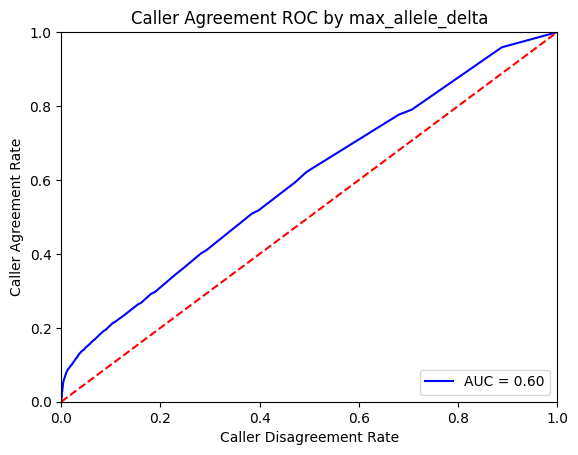

In [213]:
import sklearn.metrics as metrics
#v = x[x['max_allele_delta'] < 100]
fpr, tpr, threshold = metrics.roc_curve(x[0], x['max_allele_delta'])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Caller Agreement ROC by max_allele_delta')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Caller Agreement Rate')
plt.xlabel('Caller Disagreement Rate')
plt.show()

In [196]:
x['hipstate'].mean(), x['gangstate'].mean()

(0.6891504351429756, 0.505412349772068)

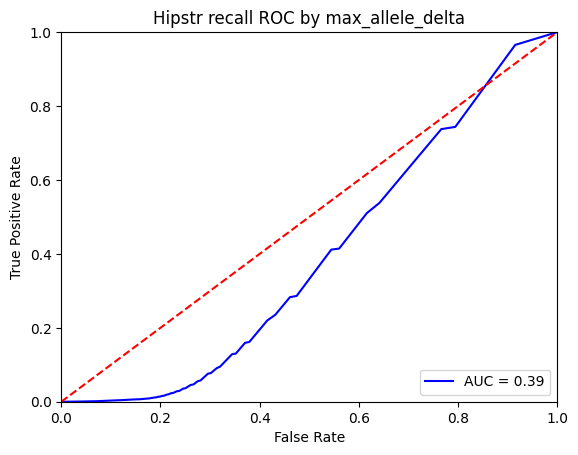

In [215]:
import sklearn.metrics as metrics
#v = x[x['max_allele_delta'] < 100]
#x.sort_values('gangstate', inplace=True)
fpr, tpr, threshold = metrics.roc_curve(x['gangstate'], x['max_allele_delta'])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Hipstr recall ROC by max_allele_delta')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Rate')
plt.show()

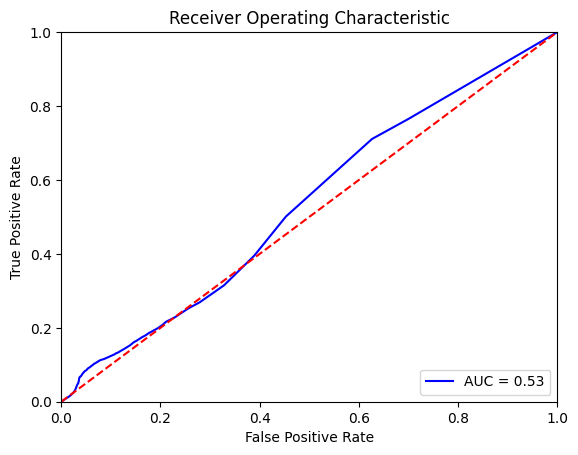

In [186]:
import sklearn.metrics as metrics
#v = x[x['max_allele_delta'] < 100]
tpr, fpr, threshold = metrics.roc_curve(x[0], x['max_motif'])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [68]:
x[x['max_allele_delta'] >= 400][0].mean()

0.8870967741935484

In [74]:
for i in ['hipstate', 'gangstate']:
    print(i)
    print(x[x['max_allele_delta'] >= 300][i].str.startswith('T').mean())
    print(x[x['max_allele_delta'] < 300][i].str.startswith('T').mean())

hipstate
0.013908205841446454
0.7056396148555708
gangstate
0.015994436717663423
0.5173637644981065


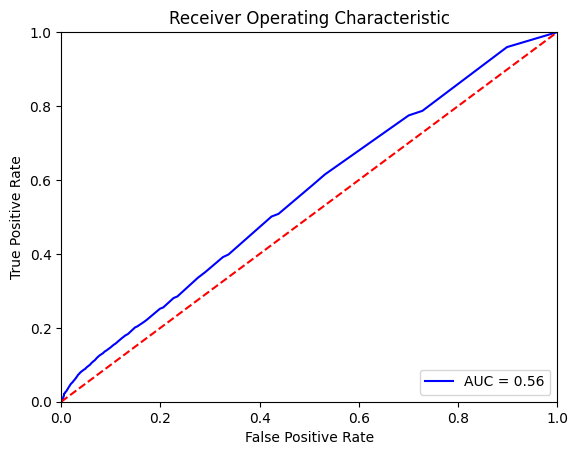

In [216]:
sr_callers_agree[sr_callers_agree.index.isin(t1_index)
                & sr_callers_agree.index.isin(gt5_index)
                & to_analyze].mean()

0.7415665147119768

In [217]:
lr_callers_agree[lr_callers_agree.index.isin(t1_index)
                & lr_callers_agree.index.isin(gt5_index)
                & to_analyze].value_counts()

True     59112
False     1213
dtype: int64

In [218]:
lr_callers_agree[lr_callers_agree.index.isin(t1_index)
                & lr_callers_agree.index.isin(gt5_index)
                & to_analyze].mean()

0.9798922503108164

In [219]:
v = data[sr_callers_agree
        & lr_callers_agree
        & data.index.isin(t1_index)
        & data.index.isin(gt5_index)
        & to_analyze][['state_hipstr', 'state_trgt']].value_counts().unstack().fillna(0).astype(int)
v

state_trgt,FN,"FN,FP",FP,TN,TP
state_hipstr,,,,,
FN,72,22,35,133,14959
"FN,FP",5,14,0,5,459
FP,3,7,41,2,91
TN,0,0,0,1,13
TP,4,1,0,69,27854


In [220]:
v.loc[:"FP"][["TN", "TP"]]

state_trgt,TN,TP
state_hipstr,,
FN,133,14959
"FN,FP",5,459
FP,2,91


In [221]:
v.loc[["TN", "TP"], :"FP"]

state_trgt,FN,"FN,FP",FP
state_hipstr,,,
TN,0,0,0
TP,4,1,0


In [222]:
v.loc[:"FP", :"FP"]

state_trgt,FN,"FN,FP",FP
state_hipstr,,,
FN,72,22,35
"FN,FP",5,14,0
FP,3,7,41


In [223]:
tmp = pd.DataFrame([["both", v.loc[("TP", "TP")] + v.loc[("TN", "TN")]],
                    ["only_lr", v.loc[:"FP"][["TN", "TP"]].sum().sum()],
                    ["only_sr", v.loc[["TN", "TP"], :"FP"].sum().sum()]],
                    #['neither', v.loc[:"FP", :"FP"].sum().sum()]],
                   columns=['which', 'cnt'])
tmp['pct'] = tmp['cnt'] /  tmp['cnt'].sum()
print(tmp['cnt'].sum())
tmp

43509


,which,cnt,pct
0,both,27855,0.640212
1,only_lr,15649,0.359673
2,only_sr,5,0.000115


In [18]:
tmp = pd.DataFrame([["both", v.loc[("TP", "TP")] + v.loc[("TN", "TN")]],
                    ["only_lr", v.loc[:"FP"][["TN", "TP"]].sum().sum()],
                    ["only_sr", v.loc[["TN", "TP"], :"FP"].sum().sum()]],
                    #['neither', v.loc[:"FP", :"FP"].sum().sum()]],
                   columns=['which', 'cnt'])
tmp['pct'] = tmp['cnt'] /  tmp['cnt'].sum()
print(tmp['cnt'].sum())
tmp

40546


,which,cnt,pct
0,both,27807,0.685814
1,only_lr,12734,0.314063
2,only_sr,5,0.000123


In [224]:
# What are lr getting that sr aren't?

subset = (to_analyze 
          & sr_callers_agree 
          & lr_callers_agree 
          & data.index.isin(t1_index) 
          & data.index.isin(gt5_index))

both_mask = data[subset]['state_hipstr'].str.startswith('T') & data[subset]['state_trgt'].str.startswith('T')
lr_mask = ~data[subset]['state_hipstr'].str.startswith('T') & data[subset]['state_trgt'].str.startswith('T')

lro = benchmark_regions.loc[lr_mask[lr_mask].index]
both = benchmark_regions.loc[both_mask[both_mask].index]


In [225]:
a = lro[['max_allele_delta', 'entropy', 'span', 'mu_purity', 'max_motif']].describe().T
a = a.set_index(pd.MultiIndex.from_tuples([(_, 'lr_only') for _ in a.index]))
b = both[['max_allele_delta', 'entropy', 'span', 'mu_purity', 'max_motif']].describe().T
b = b.set_index(pd.MultiIndex.from_tuples([(_, 'both') for _ in b.index]))
view = pd.concat([a, b]).sort_index()
view

count        mean         std        min  \
entropy          both     27937.0    0.889615    0.054278   0.480618   
                 lr_only  15649.0    0.889898    0.091435   0.411906   
max_allele_delta both     27937.0   11.482299   14.741450   5.000000   
                 lr_only  15649.0  117.097642  451.225270   5.000000   
max_motif        both     27937.0    6.668039   26.078946   2.000000   
                 lr_only  15649.0   48.062879   78.166064   2.000000   
mu_purity        both     27937.0   95.462254    2.447519  79.000000   
                 lr_only  15649.0   91.878842    2.559745  76.000000   
span             both     27937.0  125.275441  151.019236  27.000000   
                 lr_only  15649.0  597.245255  752.579369  20.000000   

                                 25%         50%         75%           max  
entropy          both       0.856260    0.893772    0.927429      0.999828  
                 lr_only    0.838969    0.908548    0.970982      0.999930  
max_allele_delta both       6.000000    9.000000   14.000000   1588.000000  
                 lr_only   10.000000   21.000000   64.000000  17516.000000  
max_motif        both       2.000000    3.000000    5.000000    481.000000  
                 lr_only    6.000000   17.000000   42.000000    495.000000  
mu_purity        both      94.000000   96.000000   97.000000    100.000000  
                 lr_only   90.000000   92.000000   94.000000     99.000000  
span             both      83.000000   93.000000  107.000000   3289.000000  
                 lr_only  207.000000  424.000000  773.000000  23939.000000

In [226]:
# Ranksum
from scipy.stats import ranksums

check = [('greater', 'max_allele_delta'),
         ('greater', 'span'),
         ('greater', 'max_motif'),
         ('less', 'mu_purity'),
         ('less', 'entropy')]
rows = []
for alt, c in check:
    result = ranksums(lro[c], both[c], alternative=alt)
    lstat = lro[c].describe()
    bstat = both[c].describe()
    rows.append([c, 
                 bstat['mean'], bstat['std'], bstat['50%'],
                 lstat['mean'], lstat['std'], lstat['50%'],
                 alt, result.pvalue, result.statistic])
result = pd.DataFrame(rows, columns=['annotation', 'both mean', 'both std', 'both median',
                                     'long-read only mean', 'long-read only std', 'long-read only median',
                                     'alternate', 'p-value', 'statistic'])
result.set_index('annotation')

,both mean,both std,both median,long-read only mean,long-read only std,long-read only median,alternate,p-value,statistic
annotation,,,,,,,,,
max_allele_delta,11.482299,14.741450,9.000000,117.097642,451.225270,21.000000,greater,0.0,85.850208
span,125.275441,151.019236,93.000000,597.245255,752.579369,424.000000,greater,0.0,141.676068
max_motif,6.668039,26.078946,3.000000,48.062879,78.166064,17.000000,greater,0.0,129.868668
mu_purity,95.462254,2.447519,96.000000,91.878842,2.559745,92.000000,less,0.0,-119.262192
entropy,0.889615,0.054278,0.893772,0.889898,0.091435,0.908548,less,1.0,18.125866


# TR vs WGS caller

In [22]:
any_hip = data['state_hipstr'].str.startswith('T')
any_gang = data['state_gangstr'].str.startswith('T')
any_trgt = data['state_trgt'].str.startswith('T')
any_medaka = data['state_medakaTR'].str.startswith('T')
any_bg = data['state_biograph'].str.startswith('T')
any_snif = data['state_sniffles'].str.startswith('T')
any_dv = data['state_deepvariant'].str.startswith('T')

wgs_tr = any_dv | any_bg | any_snif
the_tr = any_hip | any_gang | any_trgt | any_medaka

In [23]:
len(gt5_index) # How many regions are we dealing with?

101704

 Of the benchmark’s 101,704 Tier1 HG002 ≥5bp regions, the TR callers had at least one TP state in 101,1080 (99.4%) regions and 90,996 (89.4%) regions had a TP state from any WGS caller. Intersecting the two sets we found 90,812 (89.2%) are TP in the sets’ union, 10,296 (10.1%) are found to be TP exclusively by the TR callers, and only 184 are exclusive to the WGS callers. Interestingly, both the long-read and short-read TR callers contribute to the set of regions found exclusively by TR callers at 99.8% and 3.4% of regions, respectively. 

In [24]:
# TR had at least one TP:
the_tr[the_tr.index.isin(gt5_index)].value_counts()

True     101124
False       580
dtype: int64

In [26]:
101124 / 101704

0.9942971761189334

In [28]:
# WGS had at least one TP:
wgs_tr[wgs_tr.index.isin(gt5_index)].value_counts()

True     90996
False    10708
dtype: int64

In [29]:
90996 / 101704

0.8947140722095492

In [30]:
(the_tr[the_tr.index.isin(gt5_index)] & wgs_tr[wgs_tr.index.isin(gt5_index)]).value_counts()

True     90818
False    10886
dtype: int64

In [31]:
90818 / 101704

0.8929638952253599

In [32]:
(the_tr[the_tr.index.isin(gt5_index)] & ~wgs_tr[wgs_tr.index.isin(gt5_index)]).value_counts()

False    91398
True     10306
dtype: int64

In [33]:
(~the_tr[the_tr.index.isin(gt5_index)] & wgs_tr[wgs_tr.index.isin(gt5_index)]).value_counts()

False    101526
True        178
dtype: int64

In [34]:
tr_exclusive = the_tr & ~wgs_tr

In [35]:
tr_exclusive[tr_exclusive.index.isin(gt5_index)].value_counts() # 10296

False    91398
True     10306
dtype: int64

In [36]:
sr_contribute = (tr_exclusive & (any_hip | any_gang))
sr_contribute[sr_contribute.index.isin(gt5_index)].value_counts()

False    101305
True        399
dtype: int64

In [37]:
(tr_exclusive & (any_trgt[any_trgt.index.isin(gt5_index)] | any_medaka[any_medaka.index.isin(gt5_index)])).value_counts()

False    1696571
True       10282
dtype: int64

In [38]:
print(399 / 10306)
print(10282 / 10306)

0.03871531146904716
0.9976712594605085
